# 『听』和『说』
人类通过听觉获取的信息大约占所有感知信息的 20% ~ 30%。声音存储了丰富的语义以及时序信息，由专门负责听觉的器官接收信号，产生一系列连锁刺激后，在人类大脑的皮层听区进行处理分析，获取语义和知识。近年来，随着深度学习算法上的进步以及不断丰厚的硬件资源条件，**文本转语音（Text-to-Speech, TTS）** 技术在移动、虚拟娱乐等领域得到了广泛的应用。</font>
## "听"书
使用 [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) 直接获取书籍上的文字。

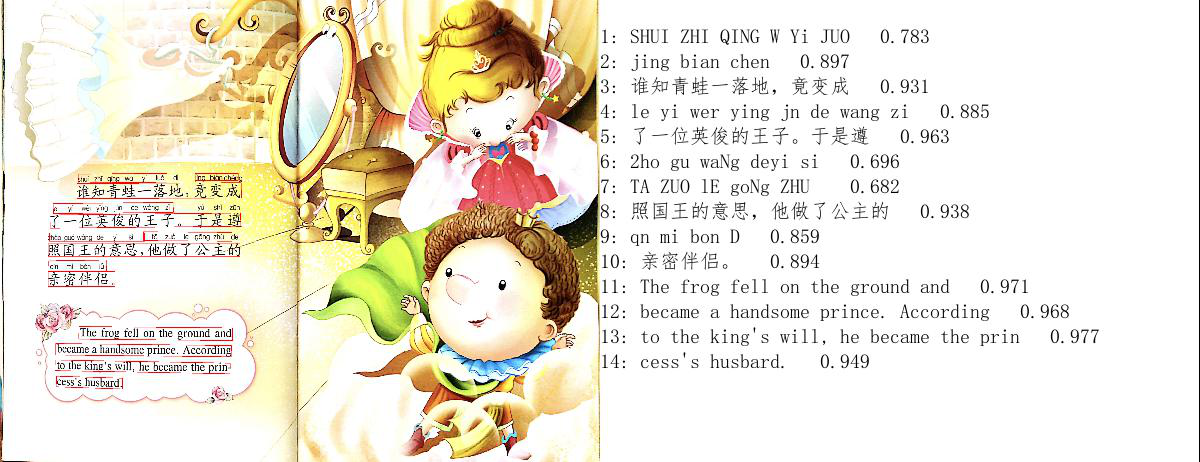

In [1]:
from PIL import Image
img_path = 'source/ocr_result.jpg'
im = Image.open(img_path)
im.show()

使用 [PaddleSpeech](https://github.com/PaddlePaddle/PaddleSpeech)，阅读上一步识别出来的文字。

In [2]:
import IPython.display as dp
dp.Audio("source/ocr.wav")

具体实现代码详见 [Story Talker](https://github.com/DeepSpeech/demos/story_talker/run.sh)

## 偶像开口说话
*元宇宙来袭，构造你的虚拟人！* 看看 [PaddleGAN](https://github.com/PaddlePaddle/PaddleGAN) 怎样合成唇形，让WiFi之母——海蒂·拉玛说话。

In [3]:
from IPython.display import HTML
html_str = '''
<video controls width="600" height="360" src="{}">animation</video>
'''.format("source/tts_lips.mp4")
dp.display(HTML(html_str))

具体实现代码请参考 [Metaverse](https://github.com/DeepSpeech/demos/metaverse/run.sh)。

下面让我们来系统地学习语音方面的知识，看看怎样使用 **PaddleSpeech** 实现基本的语音功能，以及怎样结合光学字符识别（Optical Character Recognition，OCR）、自然语言处理（Natural Language Processing，NLP）等技术“听”书、让名人开口说话。

# 前言

## 背景知识
为了更好地了解文本转语音任务的要素，我们先简要地回顾一下文本转语音的发展历史。如果你对此已经有所了解，或希望能尽快使用代码实现，请直接跳至第四章[实践](#实践)。
### 定义
<!----
Note: 
1.此句抄自 [李沐Dive into Dive Learning](https://zh-v2.d2l.ai/chapter_introduction/index.html)
2.修改参考A survey on Neural Speech Sysnthesis.
---> 
文本转语音，又称语音合成（Speech Sysnthesis），指的是将一段文本按照一定需求转化成对应的音频，这种特性决定了的输出数据比输入输入长得多。文本转语音是一项包含了语义学、声学、数字信号处理以及机器学习的等多项学科的交叉任务。虽然辨识低质量音频文件的内容对人类来说很容易，但这对计算机来说并非易事。

按照不同的应用需求，更广义的语音合成研究包括：*语音转换*，例如说话人转换、语音到歌唱转换、语音情感转换、口音转换等；*歌唱合成*，例如歌词到歌唱转换、可视语音合成等。

### 发展历史

<!--
以下摘自维基百科 https://en.wikipedia.org/wiki/Speech_synthesis
--->

在第二次工业革命之前，语音的合成主要以机械式的音素合成为主。1779年，德裔丹麦科学家 Christian Gottlieb Kratzenstein 建造了人类的声道模型，使其可以产生五个长元音。1791年， Wolfgang von Kempelen 添加了唇和舌的模型，使其能够发出辅音和元音。贝尔实验室于20世纪30年代发明了声码器（Vocoder），将语音自动分解为音调和共振，此项技术由 Homer Dudley 改进为键盘式合成器并于 1939年纽约世界博览会展出。

第一台基于计算机的语音合成系统起源于20世纪50年代。1961年，IBM 的 John Larry Kelly，以及 Louis Gerstman 使用 IBM 704 计算机合成语音，成为贝尔实验室最著名的成就之一。1975年，第一代语音合成系统之一 —— MUSA（MUltichannel Speaking Automation）问世，其由一个独立的硬件和配套的软件组成。1978年发行的第二个版本也可以进行无伴奏演唱。90 年代的主流是采用 MIT 和贝尔实验室的系统，并结合自然语言处理模型。
![语音合成技术的发展历史](./source/tts-timeline.png)

### 主流方法

当前的主流方法分为**基于统计参数的语音合成**、**波形拼接语音合成**、**混合方法**以及**端到端神经网络语音合成**。基于参数的语音合成包含隐马尔可夫模型（Hidden Markov Model,HMM）以及深度学习网络（Deep Neural Network，DNN）。端到端的方法保函声学模型+声码器以及“完全”端到端方法。


## 基于深度学习的语音合成技术

### 语音合成基本知识

![信号处理流水线](source/signal_pipeline.png)

语音合成流水线包含 <font color="#ff0000">**文本前端（Text Frontend）**</font> 、<font color="#ff0000">**声学模型（Acoustic Model）**</font> 和 <font color="#ff0000">**声码器（Vocoder）**</font> 三个主要模块:
- 通过文本前端模块将原始文本转换为字符/音素。
- 通过声学模型将字符/音素转换为声学特征，如线性频谱图、mel 频谱图、LPC 特征等。
- 通过声码器将声学特征转换为波形。

<img style="float: center;" src="source/tts_pipeline.png" width="85%"/>

# 实践
<br></br>
环境安装请参考 [install](https://github.com/PaddlePaddle/PaddleSpeech/blob/develop/docs/source/install.md)安装教程。 
下面使用 **PaddleSpeech** 提供的预训练模型合成中文语音。

## 数据及模型准备

### 获取 PaddlePaddle 预训练模型

In [ ]:
!mkdir download
!wget -P download https://paddlespeech.bj.bcebos.com/Parakeet/released_models/pwgan/pwg_baker_ckpt_0.4.zip
!unzip -d download download/pwg_baker_ckpt_0.4.zip
!wget -P download https://paddlespeech.bj.bcebos.com/Parakeet/released_models/fastspeech2/fastspeech2_nosil_baker_ckpt_0.4.zip
!unzip -d download download/fastspeech2_nosil_baker_ckpt_0.4.zip

In [4]:
!tree download/pwg_baker_ckpt_0.4
!tree download/fastspeech2_nosil_baker_ckpt_0.4

download/pwg_baker_ckpt_0.4
|-- pwg_default.yaml
|-- pwg_snapshot_iter_400000.pdz
`-- pwg_stats.npy

0 directories, 3 files
download/fastspeech2_nosil_baker_ckpt_0.4
|-- default.yaml
|-- energy_stats.npy
|-- phone_id_map.txt
|-- pitch_stats.npy
|-- snapshot_iter_76000.pdz
`-- speech_stats.npy

0 directories, 6 files


### 导入 Python 包

In [25]:
%load_ext autoreload
%autoreload 2

# 设置 gpu 环境
%env CUDA_VISIBLE_DEVICES=0

import logging
import sys
import warnings
warnings.filterwarnings('ignore')

# 需要将PaddleSpeech项目的根目录放到Python路径中
sys.path.insert(0,"../../../")

env: CUDA_VISIBLE_DEVICES=0


In [28]:
import argparse
import os
from pathlib import Path
import IPython.display as dp
import matplotlib.pyplot as plt
import numpy as np
import paddle
import soundfile as sf
import yaml
from paddlespeech.t2s.frontend.zh_frontend import Frontend
from paddlespeech.t2s.models.fastspeech2 import FastSpeech2
from paddlespeech.t2s.models.fastspeech2 import FastSpeech2Inference
from paddlespeech.t2s.models.parallel_wavegan import PWGGenerator
from paddlespeech.t2s.models.parallel_wavegan import PWGInference
from paddlespeech.t2s.modules.normalizer import ZScore
from yacs.config import CfgNode

### 设置预训练模型的路径

In [30]:
fastspeech2_config = "download/fastspeech2_nosil_baker_ckpt_0.4/default.yaml"
fastspeech2_checkpoint = "download/fastspeech2_nosil_baker_ckpt_0.4/snapshot_iter_76000.pdz"
fastspeech2_stat = "download/fastspeech2_nosil_baker_ckpt_0.4/speech_stats.npy"
pwg_config = "download/pwg_baker_ckpt_0.4/pwg_default.yaml"
pwg_checkpoint = "download/pwg_baker_ckpt_0.4/pwg_snapshot_iter_400000.pdz"
pwg_stat = "download/pwg_baker_ckpt_0.4/pwg_stats.npy"
phones_dict = "download/fastspeech2_nosil_baker_ckpt_0.4/phone_id_map.txt"
# 读取 conf 配置文件并结构化
with open(fastspeech2_config) as f:
    fastspeech2_config = CfgNode(yaml.safe_load(f))
with open(pwg_config) as f:
    pwg_config = CfgNode(yaml.safe_load(f))
print("========Config========")
print(fastspeech2_config)
print("---------------------")
print(pwg_config)

========Config========
batch_size: 64
f0max: 400
f0min: 80
fmax: 7600
fmin: 80
fs: 24000
max_epoch: 1000
model:
  adim: 384
  aheads: 2
  decoder_normalize_before: True
  dlayers: 4
  dunits: 1536
  duration_predictor_chans: 256
  duration_predictor_kernel_size: 3
  duration_predictor_layers: 2
  elayers: 4
  encoder_normalize_before: True
  energy_embed_dropout: 0.0
  energy_embed_kernel_size: 1
  energy_predictor_chans: 256
  energy_predictor_dropout: 0.5
  energy_predictor_kernel_size: 3
  energy_predictor_layers: 2
  eunits: 1536
  init_dec_alpha: 1.0
  init_enc_alpha: 1.0
  init_type: xavier_uniform
  pitch_embed_dropout: 0.0
  pitch_embed_kernel_size: 1
  pitch_predictor_chans: 256
  pitch_predictor_dropout: 0.5
  pitch_predictor_kernel_size: 5
  pitch_predictor_layers: 5
  positionwise_conv_kernel_size: 3
  positionwise_layer_type: conv1d
  postnet_chans: 256
  postnet_filts: 5
  postnet_layers: 5
  reduction_factor: 1
  stop_gradient_from_energy_predictor: False
  stop_gradient

## 文本前端（Text Frontend）


一个文本前端模块主要包含:
- 分段（Text Segmentation）
- 文本正则化（Text Normalization, TN）
- 分词（Word Segmentation, 主要是在中文中）
- 词性标注（Part-of-Speech, PoS）
- 韵律预测（Prosody）
- 字音转换（Grapheme-to-Phoneme，G2P）
<br></br>
<font size=2>（Grapheme: **语言**书写系统的最小有意义单位; Phoneme: 区分单词的最小**语音**单位）</font>
    - 多音字（Polyphone）
    - 变调（Tone Sandhi）
        - “一”、“不”变调
        - 三声变调
        - 轻声变调
        - 儿化音
        - 方言
- ...
<br></br>

（输入给声学模型之前，还需要把音素序列转换为 id）


其中最重要的模块是<font color="#ff0000"> 文本正则化 </font>模块和<font color="#ff0000"> 字音转换（TTS 中更常用 G2P 代指） </font>模块。


各模块输出示例:
```text
• Text: 全国一共有112所211高校
• Text Normalization: 全国一共有一百一十二所二一一高校
• Word Segmentation: 全国/一共/有/一百一十二/所/二一一/高校/
• G2P（注意此句中“一”的读音）:
    quan2 guo2 yi2 gong4 you3 yi4 bai3 yi1 shi2 er4 suo3 er4 yao1 yao1 gao1 xiao4
    （可以进一步把声母和韵母分开）
    q uan2 g uo2 y i2 g ong4 y ou3 y i4 b ai3 y i1 sh i2 er4 s uo3 er4 y ao1 y ao1 g ao1 x iao4
    （把音调和声韵母分开）
    q uan g uo y i g ong y ou y i b ai y i sh i er s uo er y ao y ao g ao x iao
    0 2 0 2 0 2 0 4 0 3 ...
• Prosody (prosodic words #1, prosodic phrases #2, intonation phrases #3, sentence #4):
    全国#2一共有#2一百#1一十二所#2二一一#1高校#4
    （分词的结果一般是固定的，但是不同人习惯不同，可能有不同的韵律）
```

<br></br>
文本前端模块的设计需要结合很多专业的语义学知识和经验。人类在读文本的时候可以自然而然地读出正确的发音，但是这些先验知识计算机并不知晓。
例如，对于一个句子的分词：

```text
我也想过过过儿过过的生活
我也想/过过/过儿/过过的/生活

货拉拉拉不拉拉布拉多
货拉拉/拉不拉/拉布拉多

南京市长江大桥
南京市长/江大桥
南京市/长江大桥
```
或者是词的变调和儿化音：
```
你要不要和我们一起出去玩？
你要不（2声）要和我们一（4声）起出去玩（儿）？

不好，我要一个人出去。
不（4声）好，我要一（2声）个人出去。

（以下每个词的所有字都是三声的，请你读一读，体会一下在读的时候，是否每个字都被读成了三声？）
纸老虎、虎骨酒、展览馆、岂有此理、手表厂有五种好产品
```
又或是多音字，这类情况通常需要先正确分词：
```text
人要行，干一行行一行，一行行行行行;
人要是不行，干一行不行一行，一行不行行行不行。

佟大为妻子产下一女

海水朝朝朝朝朝朝朝落
浮云长长长长长长长消
```

PaddleSpeech Text-to-Speech的文本前端解决方案:
- [文本正则](https://github.com/PaddlePaddle/PaddleSpeech/tree/develop/examples/other/tn)
- [G2P](https://github.com/PaddlePaddle/PaddleSpeech/tree/develop/examples/other/g2p):
    - 多音字模块: pypinyin/g2pM
    - 变调模块: 用分词 + 规则
<br></br>

### 构造文本前端对象
<font size=4>传入`phones_dict`，把相应的`phones`转换成`phone_ids`。</font>

In [31]:
# 传入 phones_dict 会把相应的 phones 转换成 phone_ids
frontend = Frontend(phone_vocab_path=phones_dict)
print("Frontend done!")

Frontend done!


### 调用文本前端

文本前端对输入的数据进行正则化的时候会进行分句，你也可以将以下`input`替换成`"我每天中午12:00起床"`或者`"我出生于2005/11/08，那天的最低气温达到-10°C"`。
若`merge_sentences`设置为`False`，则多个子句并行调用声学模型和声码器提升合成速度；若`merge_sentences`设置为`True`，`input_ids["phone_ids"][0]`则表示整句的`phone_ids`。

In [35]:
input = "你好，欢迎使用百度飞桨框架进行深度学习研究！"
input_ids = frontend.get_input_ids(input, merge_sentences=True, print_info=True)
phone_ids = input_ids["phone_ids"][0]
print("phone_ids:%s"%phone_ids)

----------------------------
text norm results:
['你好，', '欢迎使用百度飞桨框架进行深度学习研究！']
----------------------------
g2p results:
[['n', 'i2', 'h', 'ao3', 'sp', 'h', 'uan1', 'ing2', 'sh', 'iii3', 'iong4', 'b', 'ai3', 'd', 'u4', 'f', 'ei1', 'j', 'iang3', 'k', 'uang1', 'j', 'ia4', 'j', 'in4', 'x', 'ing2', 'sh', 'en1', 'd', 'u4', 'x', 've2', 'x', 'i2', 'ian2', 'j', 'iou1', 'sp']]
----------------------------
phone_ids:Tensor(shape=[39], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [155, 73 , 71 , 29 , 179, 71 , 199, 126, 177, 115, 138, 37 , 9  , 40 ,
        186, 69 , 46 , 151, 89 , 152, 204, 151, 80 , 151, 123, 260, 126, 177,
        51 , 40 , 186, 260, 251, 260, 73 , 83 , 151, 140, 179])


## 用深度学习实现文本前端
<img style="float: center;" src="source/text_frontend_struct.png" width="100%"/>

## 声学模型（Acoustic Model）

声学模型将字符/音素转换为声学特征，如线性频谱图、mel 频谱图、LPC 特征等，声学特征以 “帧” 为单位，一般一帧是 10ms 左右，一个音素一般对应 5~20 帧左右, 声学模型需要解决的是 <font color="#ff0000">“不等长序列间的映射问题”</font>，“不等长”是指，同一个人发不同音素的持续时间不同，同一个人在不同时刻说同一句话的语速可能不同，对应各个音素的持续时间不同，不同人说话的特色不同，对应各个音素的持续时间不同。这是一个困难的“一对多”问题。
```
# 卡尔普陪外孙玩滑梯
000001|baker_corpus|sil 20 k 12 a2 4 er2 10 p 12 u3 12 p 9 ei2 9 uai4 15 s 11 uen1 12 uan2 14 h 10 ua2 11 t 15 i1 16 sil 20
```

声学模型主要分为自回归模型和非自回归模型，其中自回归模型在 `t` 时刻的预测需要依赖 `t-1` 时刻的输出作为输入，预测时间长，但是音质相对较好，非自回归模型不存在预测上的依赖关系，预测时间快，音质相对较差。

<br></br>
主流声学模型发展的脉络:
- 自回归模型:
    - Tacotron
    - Tacotron2
    - Transformer TTS
- 非自回归模型:
    - FastSpeech
    - SpeedySpeech
    - FastPitch
    - FastSpeech2
    - ...
 
<br></br>
在本教程中，我们使用 `FastSpeech2` 作为声学模型。
![FastSpeech2](source/fastspeech2.png)

PaddleSpeech TTS 实现的 FastSpeech2 与论文不同的地方在于，我们使用的的是 phone 级别的 `pitch` 和 `energy`(与 FastPitch 类似)。
![FastPitch](source/fastpitch.png)

更多关于[声学模型的发展及改进](https://paddlespeech.readthedocs.io/en/latest/tts/models_introduction.html)。

### 初始化声学模型 FastSpeech2

In [29]:
with open(phones_dict, "r") as f:
    phn_id = [line.strip().split() for line in f.readlines()]
vocab_size = len(phn_id)
print("vocab_size:", vocab_size)
odim = fastspeech2_config.n_mels
model = FastSpeech2(
    idim=vocab_size, odim=odim, **fastspeech2_config["model"])
# 加载预训练模型参数
model.set_state_dict(paddle.load(fastspeech2_checkpoint)["main_params"])
# 推理阶段不启用 batch norm 和 dropout
model.eval()
stat = np.load(fastspeech2_stat)
# 读取数据预处理阶段数据集的均值和标准差
mu, std = stat
mu, std = paddle.to_tensor(mu), paddle.to_tensor(std)
# 构造归一化的新模型
fastspeech2_normalizer = ZScore(mu, std)
fastspeech2_inference = FastSpeech2Inference(fastspeech2_normalizer, model)
fastspeech2_inference.eval()
print(fastspeech2_inference)
print("FastSpeech2 done!")

vocab_size: 268
None
FastSpeech2Inference(
  (normalizer): ZScore()
  (acoustic_model): FastSpeech2(
    (encoder): Encoder(
      (embed): Sequential(
        (0): Embedding(268, 384, padding_idx=0, sparse=False)
        (1): ScaledPositionalEncoding(
          (dropout): Dropout(p=0.2, axis=None, mode=upscale_in_train)
        )
      )
      (encoders): MultiSequential(
        (0): EncoderLayer(
          (self_attn): MultiHeadedAttention(
            (linear_q): Linear(in_features=384, out_features=384, dtype=float32)
            (linear_k): Linear(in_features=384, out_features=384, dtype=float32)
            (linear_v): Linear(in_features=384, out_features=384, dtype=float32)
            (linear_out): Linear(in_features=384, out_features=384, dtype=float32)
            (dropout): Dropout(p=0.2, axis=None, mode=upscale_in_train)
          )
          (feed_forward): MultiLayeredConv1d(
            (w_1): Conv1D(384, 1536, kernel_size=[3], padding=1, data_format=NCL)
            (w

### 调用声学模型

shepe of mel (n_frames x n_mels):
[347, 80]


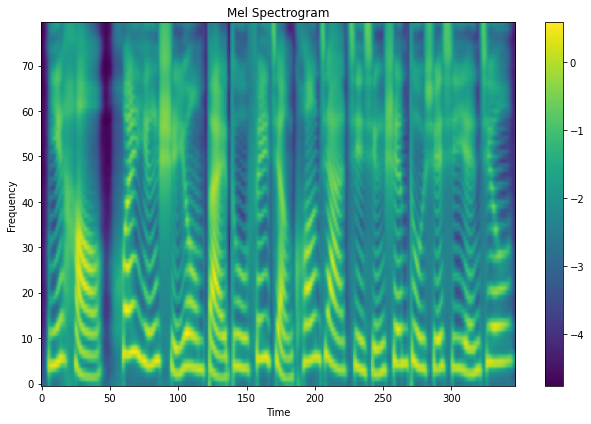

In [30]:
with paddle.no_grad():
    mel = fastspeech2_inference(phone_ids)
print("shepe of mel (n_frames x n_mels):")
print(mel.shape)
# 绘制声学模型输出的 mel 频谱
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(mel.T, aspect='auto',origin='lower')
fig.colorbar(im, ax=ax)
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

## 声码器（Vocoder）
<br></br>
声码器将声学特征转换为波形。声码器需要解决的是 <font color="#ff0000">“信息缺失的补全问题”</font>。信息缺失是指，在音频波形转换为频谱图的时候，存在**相位信息**的缺失，在频谱图转换为 mel 频谱图的时候，存在**频域压缩**导致的信息缺失；假设音频的采样率是16kHZ, 一帧的音频有 10ms，也就是说，1s 的音频有 16000 个采样点，而 1s 中包含 100 帧，每一帧有 160 个采样点，声码器的作用就是将一个频谱帧变成音频波形的 160 个采样点，所以声码器中一般会包含**上采样**模块。
    
<br></br>
与声学模型类似，声码器也分为自回归模型和非自回归模型, 更细致的分类如下:

- Autoregression
    - WaveNet
    - WaveRNN
    - LPCNet
- Flow
    - WaveFlow
    - WaveGlow
    - FloWaveNet
    - Parallel WaveNet
- GAN
    - WaveGAN
    - Parallel WaveGAN
    - MelGAN
    - HiFi-GAN
- VAE
    - Wave-VAE
- Diffusion
    - WaveGrad
    - DiffWave

<br></br>
PaddleSpeech TTS 主要实现了百度的 `WaveFlow` 和一些主流的 GAN Vocoder, 在本教程中，我们使用 `Parallel WaveGAN` 作为声码器。<

<br></br> 
<img style="float: center;" src="source/pwgan.png" width="75%"/> 

<br></br>
各 GAN Vocoder 的生成器和判别器的 Loss 的区别如下表格所示:
    
Model  | Generator Loss |Discriminator Loss
:-------------:| :------------:| :-----
Parallel Wave GAN| adversial loss <br> Feature Matching  | Multi-Scale Discriminator |
Mel GAN |adversial loss <br> Multi-resolution STFT loss  | adversial loss|
Multi-Band Mel GAN | adversial loss <br> full band Multi-resolution STFT loss <br> sub band Multi-resolution STFT loss |Multi-Scale Discriminator|
HiFi GAN |adversial loss <br> Feature Matching <br>  Mel-Spectrogram Loss | Multi-Scale Discriminator <br> Multi-Period Discriminator|


### 初始化声码器 Parallel WaveGAN

In [34]:
vocoder = PWGGenerator(**pwg_config["generator_params"])
# 模型加载预训练参数
vocoder.set_state_dict(paddle.load(pwg_checkpoint)["generator_params"]) 
vocoder.remove_weight_norm()
# 推理阶段不启用 batch norm 和 dropout
vocoder.eval()
# 读取数据预处理阶段数据集的均值和标准差
stat = np.load(pwg_stat)
mu, std = stat
mu, std = paddle.to_tensor(mu), paddle.to_tensor(std)
pwg_normalizer = ZScore(mu, std)
# 构建归一化的模型
pwg_inference = PWGInference(pwg_normalizer, vocoder)
pwg_inference.eval()
print("Parallel WaveGAN done!")

Parallel WaveGAN done!


### 调用声码器

shepe of wav (time x n_channels):[104100, 1]


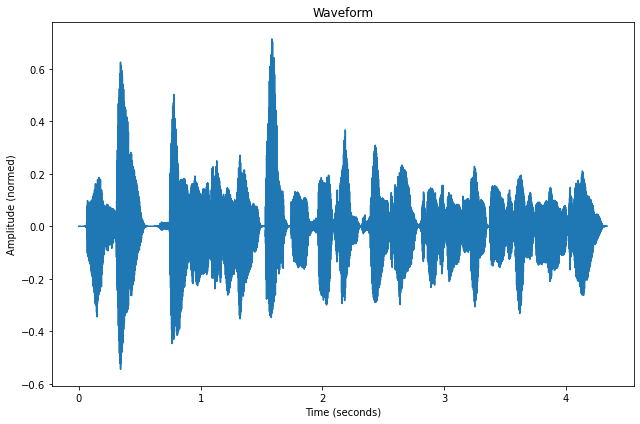

In [36]:
with paddle.no_grad():
    wav = pwg_inference(mel)
print("shepe of wav (time x n_channels):%s"%wav.shape)

# 绘制声码器输出的波形图
wave_data = wav.numpy().T
time = np.arange(0, wave_data.shape[1]) * (1.0 / fastspeech2_config.fs)
fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(time, wave_data[0])
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (normed)')
plt.tight_layout()

### 播放音频

In [ ]:
dp.Audio(wav.numpy().T, rate=fastspeech2_config.fs)

### 保存音频

In [ ]:
!mkdir output
sf.write(
    "output/output.wav",
    wav.numpy(),
    samplerate=fastspeech2_config.fs)

## 进阶 —— 个性化调节
<br></br>
FastSpeech2 模型可以个性化地调节音素时长、音调和能量，通过一些简单的调节就可以获得一些有意思的效果。例如对于以下的原始音频`"不要听信别人的谗言，我不是什么克隆人"`。

In [36]:
print("原始音频")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/speed/x1_001.wav"))
print("speed x 1.2")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/speed/x1.2_001.wav"))
print("speed x 0.8")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/speed/x0.8_001.wav"))
print("pitch x 1.3(童声)")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/child_voice/001.wav"))
print("robot")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/robot/001.wav"))

原始音频


speed x 1.2


speed x 0.8


pitch x 1.3(童声)


robot


具体实现代码请参考 [Style Fs2](https://github.com/DeepSpeech/demos/style_fs2/run.sh)。

<br></br>
## 用 PaddleSpeech 训练 TTS 模型
<br></br>
PaddleSpeech 的 examples 是按照 数据集/模型 的结构安排的:
```text
examples   
├── aishell3
│   ├── README.md
│   ├── tts3
│   └── vc0
├── csmsc
│   ├── README.md
│   ├── tts2
│   ├── tts3
│   ├── voc1
│   └── voc3
├── ...
└── ...
```
我们在每个数据集的 README.md 介绍了子目录和模型的对应关系, 在 TTS 中有如下对应关系:
```text
tts0 - Tactron2
tts1 - TransformerTTS
tts2 - SpeedySpeech
tts3 - FastSpeech2
voc0 - WaveFlow
voc1 - Parallel WaveGAN
voc2 - MelGAN
voc3 - MultiBand MelGAN
```
<br></br>
### 基于 CSMCS 数据集训练 FastSpeech2 模型
```bash
git clone https://github.com/PaddlePaddle/PaddleSpeech.git
cd examples/csmsc/tts
```
根据 README.md, 下载 CSMCS 数据集和其对应的强制对齐文件, 并放置在对应的位置
```bash
./run.sh
```
`run.sh` 中包含预处理、训练、合成、静态图推理等步骤:

```bash
#!/bin/bash
set -e
source path.sh
gpus=0,1
stage=0
stop_stage=100
conf_path=conf/default.yaml
train_output_path=exp/default
ckpt_name=snapshot_iter_153.pdz

# with the following command, you can choice the stage range you want to run
# such as `./run.sh --stage 0 --stop-stage 0`
# this can not be mixed use with `$1`, `$2` ...
source ${MAIN_ROOT}/utils/parse_options.sh || exit 1

if [ ${stage} -le 0 ] && [ ${stop_stage} -ge 0 ]; then
    # prepare data
    bash ./local/preprocess.sh ${conf_path} || exit -1
fi
if [ ${stage} -le 1 ] && [ ${stop_stage} -ge 1 ]; then
    # train model, all `ckpt` under `train_output_path/checkpoints/` dir
    CUDA_VISIBLE_DEVICES=${gpus} ./local/train.sh ${conf_path} ${train_output_path} || exit -1
fi
if [ ${stage} -le 2 ] && [ ${stop_stage} -ge 2 ]; then
    # synthesize, vocoder is pwgan
    CUDA_VISIBLE_DEVICES=${gpus} ./local/synthesize.sh ${conf_path} ${train_output_path} ${ckpt_name} || exit -1
fi
if [ ${stage} -le 3 ] && [ ${stop_stage} -ge 3 ]; then
    # synthesize_e2e, vocoder is pwgan
    CUDA_VISIBLE_DEVICES=${gpus} ./local/synthesize_e2e.sh ${conf_path} ${train_output_path} ${ckpt_name} || exit -1
fi
if [ ${stage} -le 4 ] && [ ${stop_stage} -ge 4 ]; then
    # inference with static model
    CUDA_VISIBLE_DEVICES=${gpus} ./local/inference.sh ${train_output_path} || exit -1
fi
```

### 基于 CSMCS 数据集训练 Parallel WaveGAN 模型
```bash
git clone https://github.com/PaddlePaddle/PaddleSpeech.git
cd examples/csmsc/voc1
```
根据 README.md, 下载 CSMCS 数据集和其对应的强制对齐文件, 并放置在对应的位置
```bash
./run.sh
```
`run.sh` 中包含预处理、训练、合成等步骤:
```bash
#!/bin/bash
set -e
source path.sh
gpus=0,1
stage=0
stop_stage=100
conf_path=conf/default.yaml
train_output_path=exp/default
ckpt_name=snapshot_iter_5000.pdz

# with the following command, you can choice the stage range you want to run
# such as `./run.sh --stage 0 --stop-stage 0`
# this can not be mixed use with `$1`, `$2` ...
source ${MAIN_ROOT}/utils/parse_options.sh || exit 1

if [ ${stage} -le 0 ] && [ ${stop_stage} -ge 0 ]; then
    # prepare data
    ./local/preprocess.sh ${conf_path} || exit -1
fi
if [ ${stage} -le 1 ] && [ ${stop_stage} -ge 1 ]; then
    # train model, all `ckpt` under `train_output_path/checkpoints/` dir
    CUDA_VISIBLE_DEVICES=${gpus} ./local/train.sh ${conf_path} ${train_output_path} || exit -1
fi
if [ ${stage} -le 2 ] && [ ${stop_stage} -ge 2 ]; then
    # synthesize
    CUDA_VISIBLE_DEVICES=${gpus} ./local/synthesize.sh ${conf_path} ${train_output_path} ${ckpt_name} || exit -1
fi
```

# FAQ

- 需要注意的问题
- 经验与分享
- 用户的其他问题

# 作业
在 CSMSC 数据集上利用 FastSpeech2 和 Parallel WaveGAN 实现一个中文 TTS 系统。

# 关注 PaddleSpeech
我们的 [Github地址](https://github.com/PaddlePaddle/PaddleSpeech/)，欢迎加入以下微信群参与讨论：
    
<img src="./source/wechat-group.png" width="20%" />